In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt

In [139]:
def harmonic(x, xi):
    x = x * np.ones(len(xi))
    return np.min(0.5*10*(x-xi)**2)

def sample(U, xinit,xi, nsteps, djump=0.1, xmin=0, xmax=11,
           kT=0.596, nstride=1, nprint=10000, verbose=False):
    x = xinit
    energy=U(x,xi)
    step = 0
    accepted_steps = 0
    traj = np.zeros(shape=(int(nsteps/nstride),1))
    itraj = 0

    # pre-calculate random numbers
    r = np.random.random( nsteps )
    s1 = np.random.random( nsteps )
    ## Wang Landau ##
    H = np.zeros(len(xi))
    lngf = np.zeros(len(xi))
    globef = np.zeros(len(traj))
    f = 10
    while step < nsteps:
        prev_bin = np.argmin(np.abs(x*np.ones(len(xi)) - xi))
        energy+=lngf[prev_bin]
        xnew = x + djump*(2.0*s1[step]-1.0)
        #ynew = y + djump*(2.0*s2[step]-1.0)
        bin = np.argmin(np.abs(xnew*np.ones(len(xi)) - xi))
        new_energy = U(xnew,xi)+lngf[bin]
        # calculate Metropolis acceptance 
        accept = (r[step] < min(1, np.exp( -1.0*(new_energy-energy))))

        # reject moves that bring x outside the range
        accept = accept*(xnew>xmin)*(xnew<xmax)

        if accept:
            accepted_steps += 1
            x = xnew
            energy = U(x,xi)

        if step%nstride == 0:
            traj[itraj] = x
            globef[itraj]= f
            itraj += 1

        if verbose:
            if step%nprint == 0:
                print('step', step, 'of', nsteps, ': x =', x, 'energy =', energy)

        step += 1
        H[bin] += 1
        lngf[bin] += np.log10(f)
        if np.min(H) > np.mean(H)*0.95:  # isFlat tests whether the histogram is flat (e.g. 95% flatness)
            H[:] = 0
            f *= 0.5  # Refine the f parameter
        if np.log10(f) <= -2:
            print(f'Simulation Converged in {itraj} steps')
            break
        acc_ratio = float(accepted_steps)/float(step)

    return traj,H,lngf,globef

In [140]:
centers = [0,1,2,3,4,6.5,7.5,8.5,9.5,10.5]
traj,H,lngf,globef = sample(harmonic,0,centers,int(1E7),nstride=1)

/home/tuj66686/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


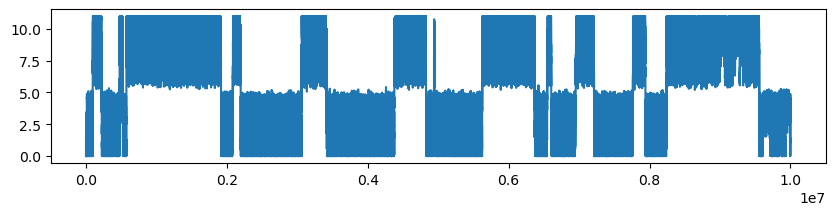

In [141]:
fig,ax = plt.subplots(figsize=(10,2))
plt.plot(traj)
#plt.xlim(1e3,1e7)
#plt.xscale('log')

In [127]:
def U(x,center):
    kt = 300 * 1.38e-23
    return 0.5 *10* (x-center)**2

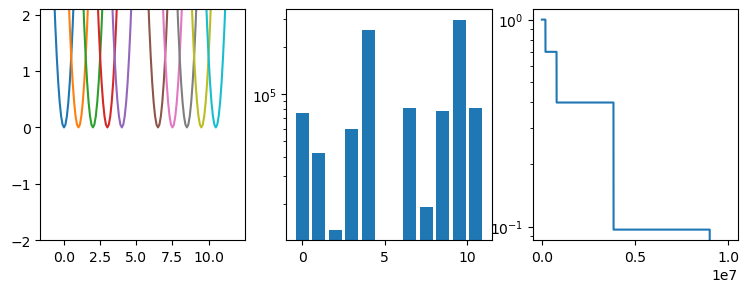

In [143]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
for i,x in enumerate(centers):
    ax[0].plot(np.arange(-1,12,0.1),U(np.arange(-1,12,0.1),x))
ax[0].set_ylim(-2,2.1)
ax[0].set_yticks(np.arange(-2,2.1,1))
ax[0].set_xticks([0,2.5,5,7.5,10])
ax[1].bar(centers,H)
ax[1].set_yscale('log')
ax[2].plot(np.log10(globef))
ax[2].set_yscale('log')

In [149]:
sys.path.append('../')
from scripts.ee_tools import *

In [159]:
def estimate_sigmas(H, lambdas, plot_data=True):
    """Using as input the Delta_U_ij energies from the dhdl array, 
    estimate the standard deviations P(U_{i-->i+1}) for neighboring ensembles.
    
    RETURNS
    sigmas   - a np.array() of standard deviations P(U_{i-->i+1}).
    """
    
    nlambdas = H.shape[0]
    print('nlambdas', nlambdas)
    
    if plot_data:
        plt.figure(figsize=(6, 80))

    Delta_uij_values = []     
    sigmas = []
       
    for j in range(nlambdas-1):
    
        ## transitions from state 0 to 1 or 1 to 2, or 2 to 3 .... 

        Ind = (lambdas == j)
        delta_u_ij = H[Ind, j+1]       # forward delta_u only for neighbored ensembles

        Ind2 = (lambdas == (j+1))
        delta_u_ji = H[Ind2, j]       # forward delta_u only for neighbored ensembles

        #print ('lambda index=', j)
        #print ('delta_u_ij.shape=', delta_u_ij.shape)
      
        #Delta_uij_values.append(delta_u_ij)

        ### VAV debug
        print('Are any delta_u_ij values nan?')
        print(delta_u_ij)
        print('Are any delta_u_ji values nan?')
        print(delta_u_ji)

        mu_ij, sigma_ij = scipy.stats.norm.fit(delta_u_ij)
        mu_ji, sigma_ji = scipy.stats.norm.fit(delta_u_ji) 
        
        sigma = ( sigma_ij + sigma_ji ) / 2.0
        sigmas.append(sigma)

        delta_u_bins = np.arange(-15., 15., 0.2)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        if plot_data:
            plt.subplot(nlambdas-1, 1, j+1)
            plt.step(bin_centers, counts, label='$\Delta u_{%d \\rightarrow %d} \sigma$=%.2f'%(j,j+1,sigma))
            #plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j, j+1))
            plt.legend(loc='best')
        
    if plot_data:
        plt.tight_layout()
        plt.show()

    ## VAV: hot fix for non-sampled lambda (sigma = nan), or sampled only once (sigma = 0)
    max_sigma = max(sigmas)
    for i in range(len(sigmas)):
        if (sigmas[i] == 0) or np.isnan(sigmas[i]):
            sigmas[i] = max_sigma


    return np.array(sigmas)

def optimize_fep_lambdas(lambdas, H, make_plots=True, save_plots=False, verbose=True):
    """
    DESCRIPTION
        Optimize the lambda values for all intermediates
        to minimize the total variance in P(\Delta u_ij) for neighboring thermodynamic ensembles
    RETURNS
        fep-lambdas (their optimized values)
    """


    lambdas = lambdas
    if verbose:
        print('lambdas', lambdas)
        print('lambdas.shape', lambdas.shape)


    sigmas = estimate_sigmas(H, lambdas, plot_data=False)
    if verbose:
        print('sigmas.shape', sigmas.shape)
 
    ### HOT FIX
    ### If any of the sigma values are zero, then we know this is one of the cases where there are duplicate
    ### fep-lambda

    print('sigmas', sigmas)
    indices_for_which_sigma_is_zero = np.where(sigmas < 0.0001)[0]
    print('indices_for_which_sigma_is_zero', indices_for_which_sigma_is_zero)

    # There should be only one such duplicate!
    if len(indices_for_which_sigma_is_zero) == 1:
        # For *THIS* particular data set we can see there is a problem:
        # The i=49 --> i+1 = 50 lambdas are the same, resulting in a sigma of zero for that transition
        # Let's remove it
     
        remove_index = indices_for_which_sigma_is_zero[0]
        print('Removing DUPLICATE lambda index:', remove_index)
        # print('sigmas', sigmas)
        sigmas_list = sigmas.tolist()
        sigmas_list.pop(remove_index)
        sigmas = np.array(sigmas_list)
        print('FIXED sigmas', sigmas)

        print('lambdas',lambdas)
        print('lambdas.shape',lambdas.shape)
        lambdas_list = lambdas.tolist()
        lambdas_list.pop(remove_index)
        lambdas = np.array(lambdas_list)
        print('FIXED lambdas',lambdas)
        print('FIXED lambdas.shape',lambdas.shape)

    elif len(indices_for_which_sigma_is_zero) > 1:
        raise Exception("There are multiple zero sigma! Are there multiple duplicates in the lambda values?!")

    else:
        print('There are no duplicate lambda')
        pass


    ### Lambda optimization

    dx = sigmas                 #according to Vince's equation (VAV: k is set to 1)
    
    x_values = np.cumsum(dx)    # convert to a list of x values of separated harmonic potentials
    x_values = np.array(np.concatenate([[0], x_values]))    # add a zero corresponding to lambda0 = 0.0
    ## VAV: This zero needs to be included.  Why was this left out before?
    print('x_values', x_values)


    from scipy.interpolate import UnivariateSpline
    from scipy.interpolate import interp1d

    if make_plots:
        plt.figure(figsize=(12,6))

    lambda_values = lambdas #not inclduing the first one, lambda_0 

    x_observed = lambda_values      #not inclduing the first one, lambda_0
    y_observed = x_values

    if make_plots:
        plt.subplot(1,2,1)
        plt.plot(x_observed, y_observed, 'ro', label = 'data')
        #plt.semilogy(x_observed, y_observed, 'ro', label = 'data')

    #y_spl = CubicSpline(x_observed, y_observed)#, s=0,k=4)  
    y_spl = UnivariateSpline(x_observed, y_observed, s=0, k=3)  
    x_range = np.linspace(x_observed[0], x_observed[-1], 1000)


    if make_plots:
        plt.plot(x_range, y_spl(x_range), label="spline")   # for UnivariateSpline
        ## plt.plot(x_observed, y_spl(x_observed), label="spline") # for CubicSpline
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('x values')

        plt.subplot(1,2, 2)   #derivative plot

    y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
    #print (y_spl_1d(x_observed))
    # y_spl_1d = y_spl(x_observed, 1)  # first derivative of Cubic spline

    if make_plots:
        plt.plot(x_range, y_spl_1d(x_range), '-')
        plt.plot(x_observed, y_spl_1d(x_observed), '.')
        plt.ylabel('dx/dlambda')
        
        #plt.plot(x_observed, y_spl_1d, '.-', label='derivative')
        plt.legend()
        plt.xlabel('lambda')

        if save_plots:
            spline_pngfile = os.path.join(outdir, f'{outname}_splinefit.png') 
            plt.savefig(spline_pngfile)
            print(f'Wrote: {spline_pngfile}')



    # Let's try a steepest descent algorithm like the kind I wrote up in "math-gradient-descent-2021-05-07.pdf" -VAV

    # run the algorithm some fixed number of steps, or until some tolerance is reached
    nsteps = 100000
    tol = 1e-7  # stop if the lambdas dont change within this tolerance

    alpha = 1e-5  # gradient descent step size
    max_del_lambda = 0.0001   # the minimization step limited to this as a maximum change

    print_every = 2000
    
    nlambdas = len(lambda_values)
    print('lambda_values', lambda_values)
    old_lambdas = np.array(lambda_values)
    traj_lambdas = np.zeros( (nlambdas,nsteps) )
    for step in range(nsteps):

        # store the trajectory of lambdas
        traj_lambdas[:,step] = old_lambdas
        if verbose:
            print('step', step, old_lambdas)
    
        # perform a steepest descent step
        new_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas[0] = 0.0   # fix the \lambda = 0 endpoint
        del_lambdas[nlambdas-1] = 0.0  # fix the \lambda = 1 endpoint
    
        if False:  # do in a loop (SLOW!) 
            for i in range(1, (nlambdas-1)):
                del_lambdas[i] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[i])*( 2.0*y_spl(old_lambdas[i]) - y_spl(old_lambdas[i-1]) - y_spl(old_lambdas[i+1]))
        else:   # do as a vector operation (FAST!) 
            y_all = y_spl(old_lambdas)
            yh, yi, yj = y_all[0:nlambdas-2], y_all[1:nlambdas-1], y_all[2:nlambdas] 
            del_lambdas[1:nlambdas-1] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[1:nlambdas-1])*( 2.0*yi - yh - yj)
        if abs(np.max(del_lambdas)) > max_del_lambda:
            del_lambdas[1:nlambdas-1] = del_lambdas[1:nlambdas-1]*max_del_lambda/np.max(del_lambdas)
        new_lambdas = old_lambdas + del_lambdas
        
        # record the average change in the lambdas 
        del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
        if step % print_every == 0:
            print('step', step, 'del_lambdas', del_lambdas)
        if del_lambdas < tol:
            print('Tolerance has been reached: del_lambdas =', del_lambdas, '< tol =', tol)
            break
        
        old_lambdas = new_lambdas


In [160]:
optimize_fep_lambdas(np.array(centers),H)

lambdas [ 0.   1.   2.   3.   4.   6.5  7.5  8.5  9.5 10.5]
lambdas.shape (10,)
nlambdas 10


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [156]:
H

array([ 75183.,  42116.,  13748.,  60059., 253608.,  82011.,  19125.,
        78061., 296595.,  81443.])